# SpO2 Signal quality
Measure Spo2 quality by using cross corelation between two consecutive R PPG segment, and correlation between R and IR segment.

## import module and declare function

In [12]:

import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
from scipy.interpolate import interp1d
import re
import pandas as pd
import math
plt.style.use('ggplot')
sys.path.insert(0, os.path.abspath('lib'))

import sig_proc as sp
import file_read

import csv

# For read maxim excel file
def maxm_reader(folder, subfolder, source):
    file_path = os.path.join(folder, subfolder)
    for f in os.listdir(file_path):
        if re.findall(source, f):
            ext = os.path.splitext(str(f))[-1].lower()
            if ext == '.csv':
                file_name = str(f)
                f_check = True
                break
            else:
                f_check = False

    if f_check:
        full_path = os.path.join(file_path, file_name)
        reader = csv.reader(open(full_path))

        dataDict = []
        for i, row in enumerate(reader):
            if i == 6:
                first_row = row[:-1] #ignore last empty value
                dataDict = {r:[] for r in first_row}
            elif i > 6:
                if row[0] == 'stop time':
                    break
                for col in range(len(first_row)):
                    if row[col] == '':
                        _value = None
                    else:
                        _value = float(row[col])
                    dataDict[first_row[col]].append(_value)
        return dataDict
    else:
        raise Exception('File not found:{}'.format(file_path))

# Normalize to mv
def value_trans(data):
    data = data*1.2/2097151.0
    return data

def ppg_preprocess(ppg_data, sr, norm=1, flip=1):
    # band pass filter parameters
    b_b, b_a = sp.bp_filter(0.5, 10, sr, 4)
    
    if flip:
        ppg_flip = sp.flip_up_down(ppg_data)
    else:
        ppg_flip = ppg_data

    # band pass filter
    filtered_ppg = signal.filtfilt(b_b, b_a, ppg_flip)
    # filtered_ppg= sp.move_avg(filtered_ppg, 5)
    if norm:
        filtered_ppg = sp.z_score(filtered_ppg)
    return filtered_ppg


def load_ppg(file_path, source):
    for f in os.listdir(file_path):
        if re.findall(source, f):
            file_name = str(f)
    if 'file_name' in locals():  
        ext = os.path.splitext(file_name)[-1].lower()
        full_path = os.path.join(file_path, file_name)
        if ext == '.csv':
            x, y = file_read.read_csv(full_path)
        else:
            x, y = file_read.read_txt(full_path)
        return x,y
    else:
        raise ValueError("file source '{}' not found!".format(source))


def pulse_seg(ppg_peak_loc, ppg_valley_loc):
    pulse_loc_set = []
    for j in range(1, len(ppg_valley_loc)):
        # find single periodic wave
        v_t0 = ppg_valley_loc[j-1]
        v_t1 = ppg_valley_loc[j]

        t_duration = (v_t1-v_t0)
        # extract single pulse
        for k, loc in enumerate(ppg_peak_loc):
            if loc > v_t0 and loc < v_t1:
                p_t1 = ppg_peak_loc[k]
                pulse_loc_set.append([v_t0, p_t1, v_t1])
    return pulse_loc_set

# Root mean square error
def rmse_calc(target, prediction):
    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])

    squaredError = []

    for val in error:
        squaredError.append(math.sqrt(val**2))
    rmseError = np.mean(squaredError)
    print(rmseError)

# Mean absolute error
def mae_calc(target, prediction):
    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])

    absError = []
    for val in error:
        absError.append(abs(val))#誤差絕對值
    maeError = np.mean(absError)
    print(maeError)


def sqi_xcorr(x,y):
    x_norm = sp.z_score(x)
    y_norm = sp.z_score(y)
    pxy = max(np.correlate(x_norm, y_norm))
#     pyy = np.correlate(y_norm, y_norm)
    pyy = sum(y_norm*y_norm)
    return (2*pxy)/pyy

# for 2 seconds version 
def sqi_xcorr_2s(x,y):
    x_norm = sp.z_score(x)
    y_norm = sp.z_score(y)
    
    pxy = max(np.correlate(x_norm, y_norm))
#     pyy = np.correlate(y_norm, y_norm)
    pyy = sum(y_norm*y_norm)
    return pxy/pyy

def RMS_amp(data):
    squaredData = []
    for val in data:
        squaredData.append(val**2)
    
    ms = np.mean(squaredData)
    rms = math.sqrt(ms)
    return rms

def spo2_calc(R_AC_component, R_DC_component, IR_AC_component, IR_DC_component, K1, K2):
    # RMS method
    R_divide = R_AC_component/R_DC_component
    R_RMS = RMS_amp(R_divide)

    IR_divide = IR_AC_component/IR_DC_component
    IR_RMS = RMS_amp(IR_divide)
    R_value = R_RMS/ IR_RMS
    
    return K1 + K2*R_value


    
def snr_calc(signal):
    return 20* math.log(np.abs(np.mean(signal)/np.std(signal)),10)

## Main function

Bad quality but R and IR not similar but the signal shows 60% similarity on pre-signal, time:16~22, xcorr:[0.74 0.86]
Bad quality but R and IR not similar but the signal shows 60% similarity on pre-signal, time:20~26, xcorr:[0.64 0.63]


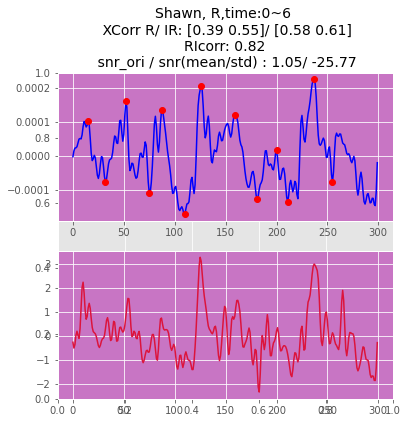

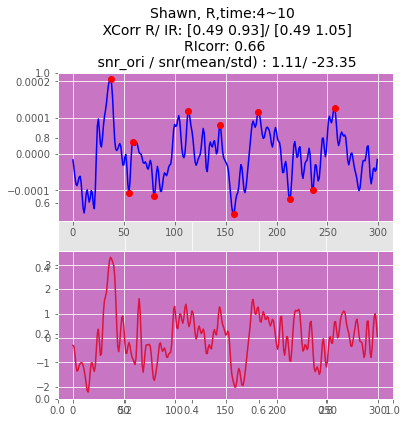

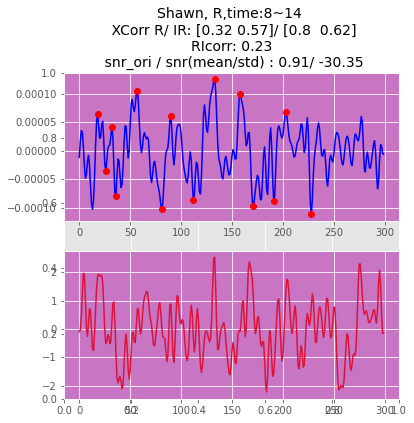

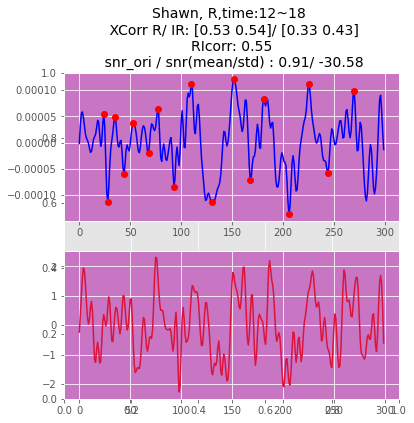

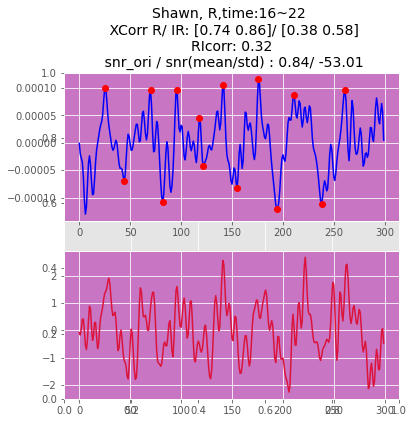

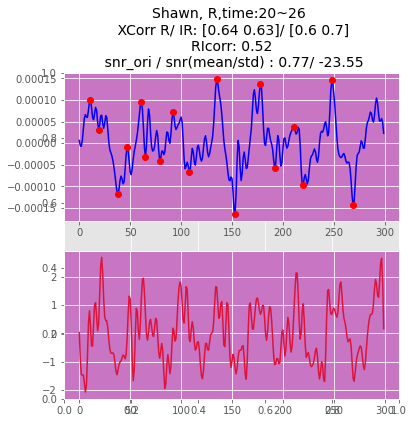

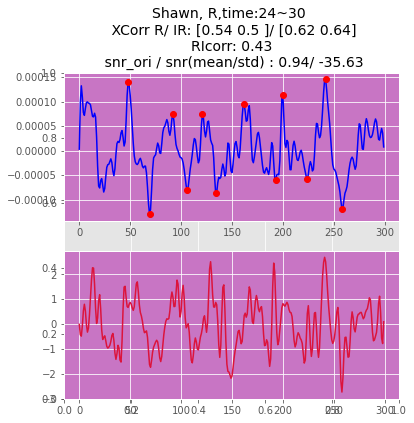

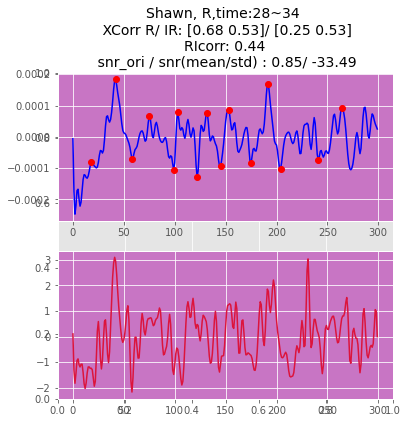

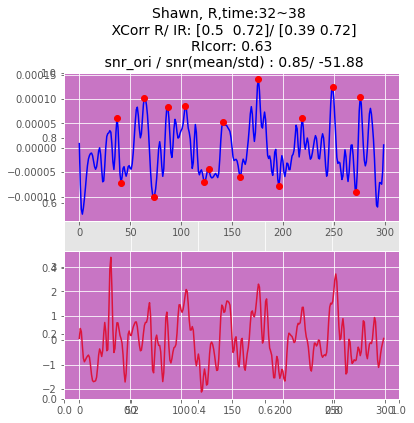

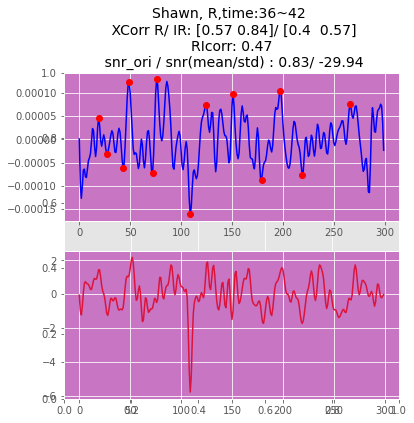

In [18]:
# Select reader
# reader = 'maxm'
# reader = 'njrc_uart'
# subfolder = 'ID01_94'

reader = ''
# folder = 'Vital sign_0708 (office)'
# folder = 'R test'
folder = 'Vital sign_0212(Week)'
# folder = 'finger'


subfolder = 'Shawn'

# subfolder = 'Luke_0708_AM'
# subfolder = 'Shawn_0708_AM'
# subfolder = 'Ryan_0708_AM'
# subfolder = 'Nicole_0708_AM'
# subfolder = 'Vanessa_0708_AM'
# subfolder = 'Yuechi_0708_AM'
# subfolder = 'Eugene_0708_AM'
# subfolder = 'Steven_0708_AM'
''' Select the duration of PPG segment in seconds'''
start_sec = 0
period = 6
overlap = 2
# overlap = 0
# data_length = len(G_y)/sr
hop_length = period - overlap
num_watching_period = 10
# num_watching_period = int((data_length - overlap)/hop_length) -1

SpO2_table = {
    #'spo2_real':[],
    'spo2':[],
    'standard':[],
    'R-AC':[],
    'R-DC':[],
    'IR-AC':[],
    'IR-DC':[],
    'R':[]
}

'''''''''''''''''''''''''''''''''''''''
        Maxim/NJRC reader
'''''''''''''''''''''''''''''''''''''''
spo2_real = []
if reader == 'maxm':
    folder = '../data/MAXIM/MAXIM SpO2'
    # Regression parameter
    K1 = 100.5
    K2 = -19.2
elif reader == 'njrc_uart':
    folder = '../data/NJRC/NJRC SpO2'
    K1 = 121.12
    K2 = -51.77
    # K1 = 114.21
    # K2 = -39.41
else:
    K1 = 121.12
    K2 = -51.77

date = '0708'
person_list = ['Luke', 'Shawn', 'Ryan', 'Nicole', 'Vanessa', 'Yuechi', 'Eugene', 'Steven']
# subfolder = 'Yuechi_0708_AM'
# subfolder = 'Eugene_0708_AM'
# subfolder = 'Steven_0708_AM'] 

# for person in person_list:
#     subfolder = person + '_' + date + '_AM'

if reader == 'maxm':
    sr = 200
    acc_sr = 200
    source = 'MAXM'
    dataDict = maxm_reader(folder, subfolder, source)
    IR_y = dataDict['LEDC2']
    R_y = dataDict['LEDC3']
    IR_y = np.array(IR_y)
    R_y = np.array(R_y)
elif reader == 'njrc_uart':
    # for uart
    sr = 200 
    acc_sr = 200
    full_path = os.path.join(folder, subfolder)
    R_x, R_y = load_ppg(full_path, '_R')
    IR_x, IR_y = load_ppg(full_path, 'IR')

    R_y = np.array(list(map(value_trans, R_y)))
    IR_y = np.array(list(map(value_trans, IR_y)))
else:
    sr = 50
    acc_sr = 50
    full_path = os.path.join("../data", folder, subfolder)
    IR_x, IR_y = load_ppg(full_path, 'IR')
    R_x, R_y = load_ppg(full_path, '_R')
    R_y = np.array(list(map(value_trans, R_y)))
    IR_y = np.array(list(map(value_trans, IR_y)))

    _, acc = load_ppg(full_path, 'ACC')
for n in range(num_watching_period):
    t1 = start_sec +  (period-overlap) * n
    t2 = t1 + period
    s1 = int(t1*sr)
    s2 = int(t2*sr )
    acc_s1 = int(t1*acc_sr)
    acc_s2 = int(t2*acc_sr )

    acc_segment = acc[acc_s1:acc_s2]
    '''''''''''''''''''''''''''''''''''''''
    Signal Preprocessing
    '''''''''''''''''''''''''''''''''''''''
    '''IR Preprocess'''
    raw_IR = np.array(IR_y[s1:s2])
    filtered_IR = ppg_preprocess(IR_y[s1:s2], sr, norm=0, flip=0)
    IR_sample_list = np.arange(len(filtered_IR))

    ''' R Preprocess'''
    raw_R = np.array(R_y[s1:s2])
    filtered_R = ppg_preprocess(R_y[s1:s2], sr, norm=0, flip=0)
    R_sample_list = np.arange(len(filtered_R))

    ''' SQI_XCORR '''
    R_AC_component = sp.butter_highpass_filter(raw_R, 0.5, sr, 4)
#     IR_AC_component = sp.butter_highpass_filter(raw_IR, 0.5, sr, 4)

#     filtered_norm_R = sp.z_score(filtered_R)
#     filtered_norm_IR = sp.z_score(filtered_IR)
    tm_length = sr*2
    tl = sr*1
    template_R = filtered_R[0:tm_length]
    template_IR = filtered_IR[0:tm_length]
    xcorr_value = []
    IR_xcorr_value = []
    for seg in range(2):

        test_signal_R = filtered_R[tm_length+tl*seg : tm_length + tl*seg + tl]
        test_signal_IR = filtered_IR[tm_length+tl*seg : tm_length + tl*seg + tl]

        xcorr_value.append(sqi_xcorr(test_signal_R, template_R))
        IR_xcorr_value.append(sqi_xcorr(test_signal_IR, template_IR))


    R_xcorr_value_2s = sqi_xcorr_2s(filtered_R[tm_length:], template_R)
    IR_xcorr_value_2s = sqi_xcorr_2s(filtered_IR[tm_length:],template_R)

    ''' R and IR correlation '''
    ricorr = sp.corrcoef(filtered_R[tm_length:], filtered_IR[tm_length:])

    ''' Finde peak and valley '''
    R_peak_loc,_, R_valley_loc, _, _ = sp.find_peak_valley(sr, filtered_R, R_sample_list)
    IR_peak_loc,_, IR_valley_loc, _, _ = sp.find_peak_valley(sr, filtered_IR, IR_sample_list)

    R_pulse_loc_set = pulse_seg(R_peak_loc, R_valley_loc)
    IR_pulse_loc_set = pulse_seg(IR_peak_loc, IR_valley_loc)

    ''' Extract AC/DC '''
    # Peak-Trough method
    # R_AC, R_DC, R_bot_x, R_bot_y= PI_calc(R_pulse_loc_set, raw_R)
    # PI_R = R_AC/R_DC

    # IR_AC, IR_DC, IR_bot_x, IR_bot_y= PI_calc(IR_pulse_loc_set, raw_IR)
    # PI_IR = IR_AC/IR_DC

    # R_curve = PI_R/PI_IR
    # SpO2 = K1 + K2*R_curve

    # RMS method
    R_DC_component = sp.butter_lowpass_filter(raw_R, 5, sr, 4)  
    IR_DC_component = sp.butter_lowpass_filter(raw_IR, 5, sr, 4)


    R_divide = filtered_R/R_DC_component
    R_RMS = RMS_amp(R_divide)

    IR_divide = filtered_IR/IR_DC_component
    IR_RMS = RMS_amp(IR_divide)
    R_ver2 = R_RMS/ IR_RMS
    spo2_ver2 =  K1 + K2*R_ver2


    # SpO2_table['spo2_real'].append(spo2_real)
    # SpO2_table['spo2'].append(SpO2)
    SpO2_table['standard'].append(subfolder)
    # SpO2_table['R-AC'].append(R_AC)
    # SpO2_table['R-DC'].append(R_DC)
    # SpO2_table['IR-AC'].append(IR_AC)
    # SpO2_table['IR-DC'].append(IR_DC)
    SpO2_table['R'].append(R_ver2)
    '''''''''''''''''''''''''''''''''''
    plot filgure
    '''''''''''''''''''''''''''''''''''
    font_size = 14
    fig_size  = (6,6)
    marker_size = 6
         # plt.vlines(tm_length, min(sp.z_score(filtered_R)),  max(sp.z_score(filtered_R)),color='red', ls='--')



        
    fig = plt.figure(figsize=fig_size)
    smooth_R = sp.move_avg(filtered_R[tm_length:], int(sr/10))
    # snr_db = sn_sqi(smooth_R,R_AC_component[tm_length:])
    snr_mean_std = snr_calc(R_AC_component[tm_length:])
    ssqi = sp.snr_calc(smooth_R, R_AC_component[tm_length:])
    sqi_str1 = 'XCorr R/ IR: {}/ {}\n'.format(np.round(xcorr_value,2), np.round(IR_xcorr_value,2))
    sqi_str2 = 'RIcorr: {}'.format(np.round(ricorr,2))
    # str1 = '\n R value 3s/test:{}, {}'.format(np.round(R_ver2,2), np.round(R_test, 2))
    # str2 = '\n SpO2 3s/ test: {}/ {}'.format(np.round(spo2_ver2,2), np.round(spo2_test, 2))
    # str3 = '\n RPI 3s/ test: {}/ {}'.format(np.round(R_RMS*100,2), np.round(R_RMS_test*100, 2))
    str4 = '\n snr_ori / snr(mean/std) : {}/ {}'.format(np.round(ssqi,2), np.round(snr_mean_std,2))
    str5 = '\n R/IR 2s xcorr: {}/ {}'.format(np.round(R_xcorr_value_2s, 2), np.round(IR_xcorr_value_2s, 2))
    plt.title('{}, R,time:{}~{} \n '.format(subfolder,t1,t2) + sqi_str1 + sqi_str2 + str4,  fontsize=font_size)
    ax1 = fig.add_subplot(211)
    plt.plot(IR_sample_list, filtered_IR, color='blue')
    plt.plot(IR_sample_list[IR_peak_loc], filtered_IR[IR_peak_loc], 'o', c='red')
    plt.plot(IR_sample_list[IR_valley_loc], filtered_IR[IR_valley_loc], 'o', c='red')
    # plt.plot(IR_sample_list[tm_length:], sp.z_score(filtered_IR[tm_length:]), color='blue')
    ax2 = fig.add_subplot(212)
    plt.plot(R_sample_list, sp.z_score(filtered_R), color='crimson')
    # plt.plot(R_sample_list[tm_length:], sp.z_score(filtered_R[tm_length:]), color='crimson')
    


    if xcorr_value[0] < 0.5 or xcorr_value[1] < 0.5 or ricorr < 0.7:
        if ricorr <0.6 and (xcorr_value[0] > 0.6 and xcorr_value[1] > 0.6):
            print('Bad quality but R and IR not similar but the signal shows 60% similarity on pre-signal, time:{}~{}, xcorr:{}'.format(t1,t2,np.round(xcorr_value,2)))        
        ax1.set_facecolor('xkcd:orchid')
        ax2.set_facecolor('xkcd:orchid')

    elif (xcorr_value[0] > 0.6 and xcorr_value[0]< 0.7) or (xcorr_value[1] > 0.6 and xcorr_value[1] < 0.7):
        ax1.set_facecolor('xkcd:pink')
        ax2.set_facecolor('xkcd:pink')
    else:
        ax1.set_facecolor('xkcd:lime')
        ax2.set_facecolor('xkcd:lime')
